# Windowpane optimization for the precise QA configuration

In [58]:
from simsopt._core import load
from simsopt.geo import create_equally_spaced_curves, create_equally_spaced_windowpane_curves
from simsopt.geo import SurfaceRZFourier, create_equally_spaced_windowpane_grid, SurfaceScaled
from simsopt.geo import curves_to_vtk
from simsopt.field import apply_symmetries_to_curves, Coil, BiotSavart
from simsopt.field import apply_symmetries_to_currents, Current, ScaledCurrent, CurrentPenalty

import os
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import simpson
from pathlib import Path
import numpy as np

from simsopt.mhd.vmec import Vmec

In [59]:
# plasma surface
surf_s = 1
surf_dof_scale = 0.165
surf_name = 'wout_NAS_n2n4_AR6.2.03.nc'

surf_s = 1
surf_dof_scale = 1
surf_name = 'wout_nfp2ginsburg_000_003186.nc'

# surf_s = 1
# surf_dof_scale = 1
# surf_name = 'wout_hbt_AR_3_finite_beta_000_000000.nc'

#surf_dof_scale = 1
#surf_name = 'wout_nfp2ginsburg_000_004484.nc'
#surf_name = 'wout_scaled_iota_015.nc'


In [96]:
nphi = 32  # nphi = ntheta >= 64 needed for accurate full-resolution runs
ntheta = 64
# Make higher resolution surface for plotting Bnormal
phi = np.linspace(0, 1, nphi, endpoint=True)
theta = np.linspace(0, 1, ntheta, endpoint=True)

1.002114425480168
0.14219320089544157


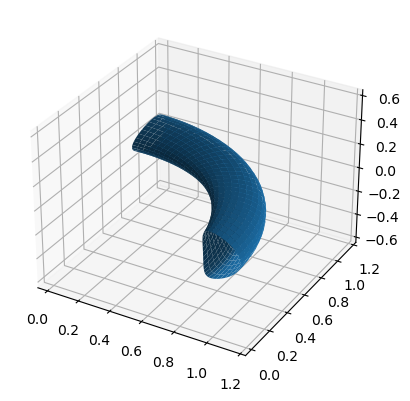

<Axes3D: >

In [97]:
# Initialize Scaled QA Surface with iota = 0.15
surf_dir = '/Users/jakehalpern/Projects/C-REX/Cleaned_up_for_Github/equilibria/'
surf_loc = surf_dir + surf_name
surf = SurfaceRZFourier.from_wout(surf_loc, s=surf_s, range='half period', nphi=nphi, ntheta=ntheta)

# surf_nfp1 = SurfaceRZFourier.from_wout(surf_loc, s=surf_s, range='half period', nphi=nphi, ntheta=ntheta)
# surf = SurfaceRZFourier(mpol=surf_nfp1.mpol,ntor=surf_nfp1.ntor,nfp=2,stellsym=True,
#                                 quadpoints_theta=surf_nfp1.quadpoints_theta,
#                                 quadpoints_phi=surf_nfp1.quadpoints_phi)
# surf.least_squares_fit(surf_nfp1.gamma())
surf.set_dofs(surf_dof_scale*surf.get_dofs())
print(surf.major_radius())
print(surf.minor_radius())
surf.plot()

0.0


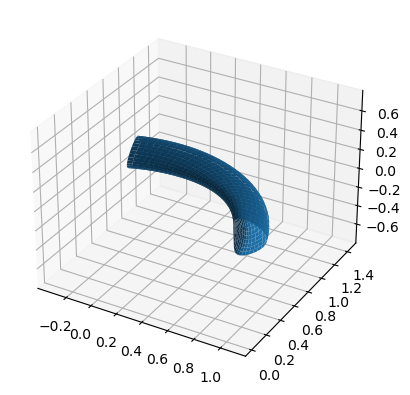

0.3141592653589793


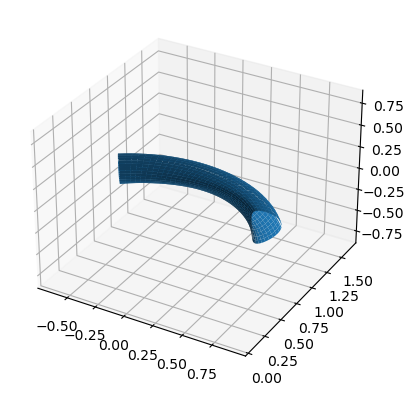

0.6283185307179586


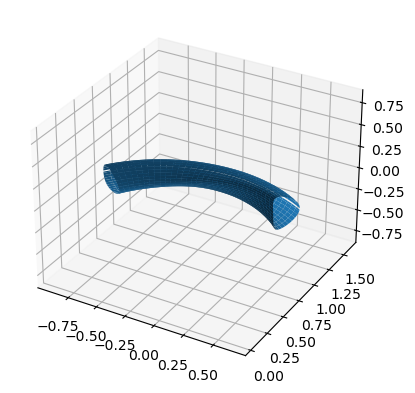

In [99]:
def rotate_toroidal_surface(x, y, z, phi, dphi):
    """
    Rotate the toroidal surface by a toroidal angle dphi.
    
    Parameters:
        x (ndarray): x-coordinates of the surface (ntheta x nphi grid).
        y (ndarray): y-coordinates of the surface (ntheta x nphi grid).
        z (ndarray): z-coordinates of the surface (ntheta x nphi grid).
        phi (ndarray): 1D array of toroidal angles (length nphi).
        dphi (float): Rotation angle in radians.
        
    Returns:
        x_rot, y_rot, z_rot (ndarray): Rotated coordinates of the surface.
    """
    # Ensure phi is a 1D array
    phi = np.asarray(phi)
    
    # Compute the new toroidal angle after rotation
    phi_rot = (phi + dphi) % (2 * np.pi)
    
    # Precompute trigonometric terms for rotation
    cos_dphi = np.cos(dphi)
    sin_dphi = np.sin(dphi)
    
    # Rotate x and y coordinates
    x_rot = cos_dphi * x - sin_dphi * y
    y_rot = sin_dphi * x + cos_dphi * y
    z_rot = z  # z remains unchanged during toroidal rotation
    
    return x_rot, y_rot, z_rot
win_phi = 10
dphi = 2 * np.pi / surf.nfp / win_phi
dphi_array = [dphi*i for i in range(3)]
for dphi_tot in dphi_array:
    surf.gamma()[:, :, 0], surf.gamma()[:, :, 1], surf.gamma()[:, :, 2] = rotate_toroidal_surface(surf.gamma()[:, :, 0], surf.gamma()[:, :, 1], surf.gamma()[:, :, 2], surf.quadpoints_phi, dphi)
    #surf.save(f'{surf_name.split(".nc")[0]}_dphi_{dphi_tot:.2f}.json')
    print(dphi_tot)
    surf.plot()


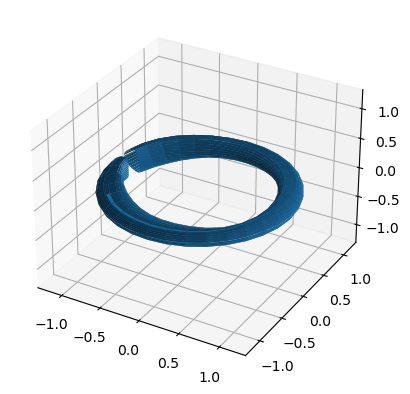

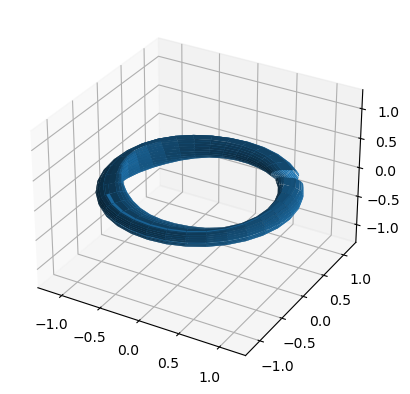

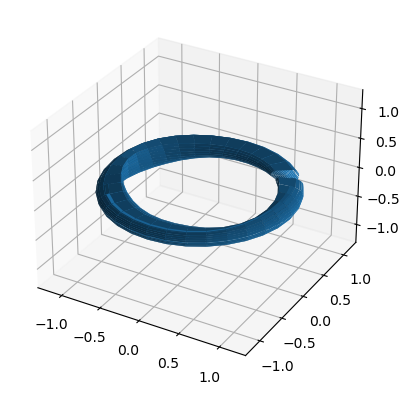

<Axes3D: >

In [86]:
def rotate_surface(surface, phi_values, dphi, plot_range):
    """
    Rotate a toroidal surface by an angle dphi and ensure it stays within the plotting range.
    
    Parameters:
    - surface: numpy array of shape (ntheta, nphi, 3), the surface coordinates.
    - phi_values: 1D numpy array of shape (nphi,), the toroidal angles in radians.
    - dphi: float, the angle (in radians) to rotate the surface toroidally.
    - plot_range: tuple of (phi_min, phi_max), the range of phi to plot (in radians).
    
    Returns:
    - rotated_surface: numpy array of shape (ntheta, nphi, 3), the rotated surface.
    - rotated_phi_values: 1D numpy array of shape (nphi,), the adjusted toroidal angles.
    """
    phi_min, phi_max = plot_range
    full_range = phi_max - phi_min

    # Rotate phi values
    rotated_phi_values = (phi_values + dphi) % 1
    
    # Map values back into the plotting range
    rotated_phi_values = phi_min + (rotated_phi_values - phi_min) % full_range
    
    # Sort the indices to maintain plotting order
    sort_indices = np.argsort(rotated_phi_values)
    rotated_phi_values = rotated_phi_values[sort_indices]
    
    # Rotate the surface points accordingly
    rotated_surface = surface[sort_indices,:, :]
    
    return rotated_surface, rotated_phi_values

phi = surf.quadpoints_phi
dphi = 0.4
plot_range = (0, 1)
surf.plot()
surf.gamma()[:,:,:], phi = rotate_surface(surf.gamma()[:, :, :], phi, dphi, plot_range)
surf.plot()

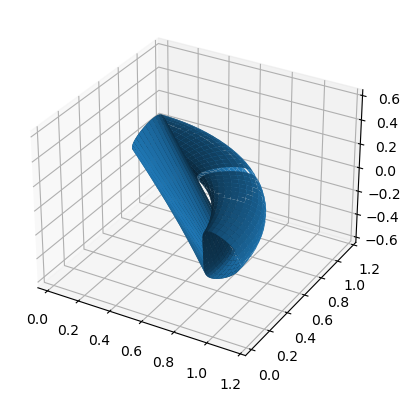

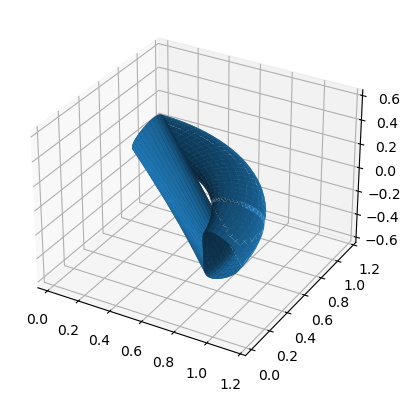

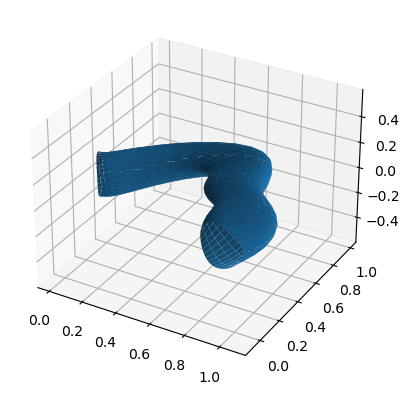

<Axes3D: >

In [93]:
def shift_gamma(gamma, dphi):
    nphi, ntheta, _ = gamma.shape  # Extract dimensions
    # Create a new array to store the shifted values
    shifted_gamma = np.zeros_like(gamma)
    
    # Calculate the shifted indices with wrapping
    for i in range(nphi):
        new_index = (i + dphi) % nphi
        shifted_gamma[new_index, :, :] = gamma[i, :, :]
    
    return shifted_gamma

surf.plot()
surf.gamma()[:,:,:] = shift_gamma(surf.gamma()[:,:,:] , nphi//4)
surf.plot()
surf_plas = SurfaceRZFourier(mpol=surf.mpol,ntor=surf.ntor,nfp=2,stellsym=True,
                                quadpoints_theta=surf.quadpoints_theta,
                                quadpoints_phi=surf.quadpoints_phi)
surf_plas.least_squares_fit(surf.gamma())
surf_plas.plot()